In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# matplotlib style
style_name = 'bmh' #bmh
mpl.style.use(style_name)
style = plt.style.library[style_name]
style_colors = [ c['color'] for c in style['axes.prop_cycle'] ]

# matplotlib 한글출력
# plt.rcParams['font.family'] = 'NanumBarunGothic'
# mpl.rc('font', family='NanumBarunGothic')
# plt.rcParams['axes.unicode_minus'] = False

np.set_printoptions(precision=4, linewidth =150)

##########################################################
# for sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

##########################################################
# for plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from IPython.core.display import display, HTML

init_notebook_mode(connected=True)

# https://github.com/plotly/plotly.py/issues/515
# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

## 다변수 회귀

### 기저함수를 사용하지 않는 경우

- 나이와 몸무게에 따른 혈압 데이터를 회귀

,혈압,나이,몸무게
0,132,52,173
1,143,59,184
2,153,67,194
3,162,73,211
4,154,64,196
5,168,74,220
6,137,54,188
7,149,61,188
8,159,65,207
9,128,46,167


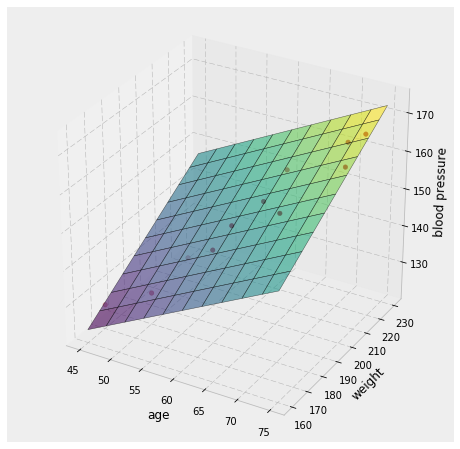

In [2]:
plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure()
ax = plt.axes(projection='3d')

# http://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/mlr/frames/mlr02.html
# col1 : 혈압 = t, col2 : 나이 = x1, col3: 몸무게 = x2
D = np.array([[132,  52, 173],
              [143,  59, 184],
              [153,  67, 194],
              [162,  73, 211],
              [154,  64, 196],
              [168,  74, 220],
              [137,  54, 188],
              [149,  61, 188],
              [159,  65, 207],
              [128,  46, 167],
              [166,  72, 217]])

df = pd.DataFrame(D)
df.columns = ['혈압', '나이','몸무게']
display(df)

X_train = D[:,1:]
T_train = D[:,0]

# Design matrix
A = np.hstack((np.ones(D.shape[0]).reshape(-1,1), D[:,1:]))
# Target vector
T = D[:,0]

# w = (A^T * A)^-1 * A^T t
W = np.linalg.solve( A.T.dot(A), A.T.dot(T) )

# [1  나이  몸무게].T * [w0, w1, w2]
x1 = np.linspace(45, 75, 50)
x2 = np.linspace(160, 230, 50)
xx1, xx2 = np.meshgrid(x1, x2)

P = W[0] + xx1*W[1] + xx2*W[2]

ax.scatter3D(D[:,1], D[:,2], D[:,0], color=style_colors[1])
ax.plot_surface(xx1, xx2, P, rstride=5, cstride=5, 
                cmap=plt.cm.viridis, edgecolor="k", alpha=0.6)

ax.set_xlabel('age')
ax.set_ylabel('weight')
ax.set_zlabel('blood pressure')
plt.show()

In [3]:
# https://plot.ly/python/
# https://plot.ly/python/offline/

# hover contour off
# https://community.plot.ly/t/trace-lines-appearing-on-hover/5801
data = [
    go.Surface(x=xx1, y=xx2, z=P, showscale=False, colorscale='Viridis', opacity=0.8,
               contours=dict(
                   x=dict(show=True, highlight=True),
                   y=dict(show=True,  highlight=True),
                   z=dict(show=True,  highlight=True),
               ),
    ),
    go.Scatter3d(x=D[:,1], y=D[:,2], z=D[:,0], mode='markers',
                 marker=dict(
                    symbol='circle', size=3,
                    line=dict(color=style_colors[1], width=0.5),
                    opacity=0.8
                 ), name="Data"
    )
]

layout = go.Layout(
    title='Systolic Blood Pressure Data',
    autosize=False, showlegend=True, 
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=25),
    scene = dict(
        xaxis = dict(title='age'),
        yaxis = dict(title='weight'),
        zaxis = dict(title='b.p.'),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

### 기저함수를 사용하는 경우

- 다음  Franke 함수라 불리는 함수로 부터 데이터를 생성

$$
f(x, y) = \frac{3}{4} e^{-\frac{1}{4}((9x-2)^2 + (9y-2)^2)} + \frac{3}{4} e ^{-\frac{1}{49}(9x+1)^2-\frac{1}{10}(9y+1)^2}+\frac{1}{2} e^{-\frac{1}{4}((9x-7)^2 + (9y-3)^2)} -\frac{1}{5}e^{-(9x-4)^2 -(9y-7)^2}
$$

- http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.307.3154&rep=rep1&type=pdf

In [4]:
# Franke test function
def franke(x, y) :
    return ( (3./4.) * np.exp(-1/4*((9*x-2)**2 + (9*y-2)**2)) 
           + (3./4.) * np.exp(-(1/49) * (9*x+1)**2 - (1/10)*(9*y+1)**2) 
           + (1./2.) * np.exp(-1/4*((9*x-7)**2 + (9*y-3)**2)) 
           - (1./5.) * np.exp(-(9*x-4)**2 - (9*y-7)**2) )

- Franke 함수 테스트

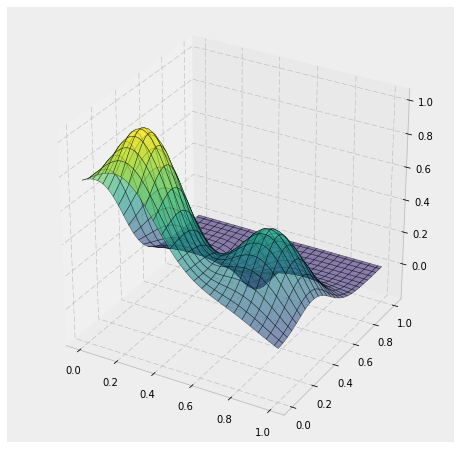

In [5]:
plt.rcParams["figure.figsize"] = (8,8)

x = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x,x)
Z = franke(X,Y)

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, rstride=2, cstride=2, 
                       cmap=plt.cm.viridis, edgecolor="k",
                      alpha=0.6)

plt.show()

In [6]:
# https://plot.ly/python/
# https://plot.ly/python/offline/

# hover contour off
# https://community.plot.ly/t/trace-lines-appearing-on-hover/5801
data = [
    go.Surface(x=X, y=Y, z=Z, showscale=False, colorscale='Viridis', opacity=0.8,
               contours=dict(
                   x=dict(show=True, highlight=True),
                   y=dict(show=True,  highlight=True),
                   z=dict(show=True,  highlight=True),
               ),
    ),
]

layout = go.Layout(
    title='Franke function',
    autosize=False, 
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=25),
    scene = dict(
        xaxis = dict(title='x'),
        yaxis = dict(title='y'),
        zaxis = dict(title='z'),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

- Franke 함수로 부터 데이터 만들기

In [7]:
np.random.seed(0)

x = np.linspace(0, 1, 50)
xx, yy= np.meshgrid(x,x)
zz = franke(xx,yy)

N = 200
X_train = np.random.rand(N, 2).T
T_train = franke(X_train[0,:], X_train[1,:])
noise = 0.05 * np.random.randn(N)
T_train = T_train + noise

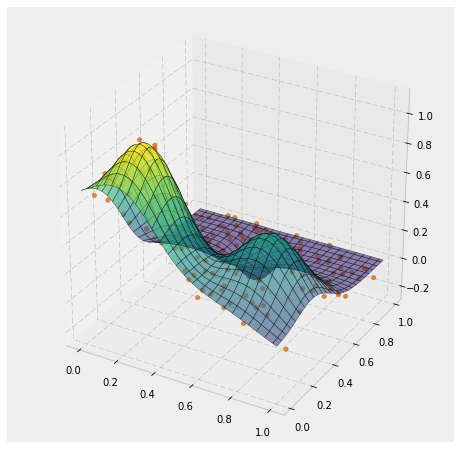

In [8]:
plt.rcParams["figure.figsize"] = (8, 8)

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=2, 
                       cmap=plt.cm.viridis, edgecolor="k",
                      alpha=0.6)

# Plot data
ax.scatter(X_train[0,:], X_train[1,:], T_train, color=style_colors[4], alpha=0.7)
ax.axis('equal')

plt.show()

In [9]:
# https://plot.ly/python/
# https://plot.ly/python/offline/
# hover contour off
# https://community.plot.ly/t/trace-lines-appearing-on-hover/5801

surf = go.Surface(x=xx, y=yy, z=zz, showscale=False, colorscale='Viridis', opacity=0.8,
               contours=dict(
                   x=dict(show=True, highlight=True),
                   y=dict(show=True,  highlight=True),
                   z=dict(show=True,  highlight=True),
               ),
    )

train = go.Scatter3d(x=X_train[0,:], y=X_train[1,:], z=T_train, mode='markers',
                 marker=dict(
                    symbol='circle', size=3,
                    line=dict(color=style_colors[1], width=0.5),
                    opacity=0.8,
                 ),
                 name='Data'
    )

data = [ surf, train ]
    
layout = go.Layout(
    title='Franke function',
    autosize=False, showlegend=True, 
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=30),
    scene = dict(
        xaxis = dict(title='x'),
        yaxis = dict(title='y'),
        zaxis = dict(title='z'),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

- 방사기저함수 정의

- 다음함수를 기저함수로 사용

$$
\phi(\mathbf{x}) = \exp \left\{ -\frac{\lVert \mathbf{x} - \boldsymbol{\mu} \rVert^2_2}{2s^2} \right\}
$$

In [10]:
# 2D-RBF(Radial Basis Function)
def rbf(x, y, mu_x, mu_y, s) :
    """
    N x N : 함수값을 계산해야하는 포인트 갯수
    M x M : 각각 다른 평균 mu를 쓰는 함수의 갯수
    
    x      : (N x N), N x N개의 x점
    y      : (N x N), N x N개의 y점
    mu_x   : (M x M), M x M개의 기저함수의 \mu에 대한 x좌표
    mu_y   : (M x M), M x M개의 기저함수의 \mu에 대한 y좌표
    return : (M^2 x N x N) M x M개의 함수에 대한 함수값 N x N개, axis=0이 함수의 인덱스
    """
    
    """
    여기서 부터 주석은 함수 4개에 60x60개 포인트에서 함수값을 계산하는 경우를 가정
    
    mu_x, (2, 2)
        [[0.25 0.75]
         [0.25 0.75]]
     
    mu_x.reshape(-1,1)[np.newaxis, :], (1, 4, 1)
        [[[0.25]
          [0.75]
          [0.25]
          [0.75]]]
        
    mux, (4, 1, 1) , axis=0를 함수의 번호로 만들어 준다.
        [[[0.25]]
          [[0.75]]
          [[0.25]]
          [[0.75]]]
    """

    mux = mu_x.reshape(-1,1)[np.newaxis, :].transpose((1,0,2))
    muy = mu_y.reshape(-1,1)[np.newaxis, :].transpose((1,0,2))
        
    # 바둑판식으로 구성된 x, y 좌표에서 빼버리면 3차원 어레이가  됨
    # x : (60,60)
    # dx.shape (4, 60, 60), 함수 4개에 대해서 60x60개의 위치에서 dx, dy를 구했음
    dx = x-mux; dy = y-muy
    
    # 4차원 어레이로 만들고, (2, 4, 60, 60)
    # D[0] : 함수 4개의 x좌표에 대한 정보 
    # D[1] : 함수 4개의 y좌표에 대한 정보
    D = np.array( [dx, dy] )

    # norm을 계산하고 함수값 계산해서 리턴
    # norm은 x, y 좌표에 대해서 연산하므로 axis=0를 따라서
    # (np.linalg.norm(D, axis=0).shape) = (4, 60, 60)
    # 따라서 리턴 결과는 (4, 60, 60) : 4개의 함수에 대한 60x60개 위치에서의 함수값 저장
    return np.exp( -(1/2)*( (np.linalg.norm(D, axis=0)**2) / (s**2)) )

- 방사기저함수 테스트



(4, 60, 60)


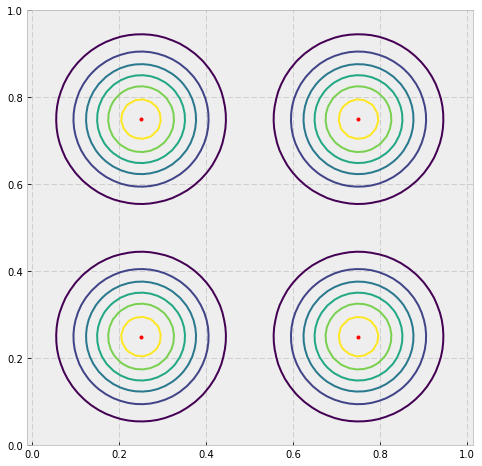

In [11]:
plt.rcParams["figure.figsize"] = (8,8)

x = np.linspace(0, 1, 60)
X, Y = np.meshgrid(x, x)

# [0.,  0.5, 1. ]
span = np.linspace(0, 1, 3)

# mu : [0.25, 0.75]
mu = (span[:-1] + span[1:])/2
MU_X, MU_Y = np.meshgrid(mu, mu)
M = mu.shape[0]**2

# X, Y : 함수의 값을 계산해야하는 도메인의 메쉬그리드
# MU_X, MU_Y : 4개의 함수의 MU값을 저장한 변수
# Z.shape : (4, 60, 60) , 4개의 함수에 대해 60x60그리드의 함수값 저장
Z = rbf(X,Y, MU_X, MU_Y, 0.1)
print(Z.shape)
# 방사기저함수의 평균점(중심점)을 찍는다.
plt.plot(MU_X, MU_Y, 'r.')

# 4개의 함수를 돌아가면서 윤곽선을 그린다.
for z in Z : 
    plt.contour(X, Y, z)
    
plt.axis('equal')
plt.show()

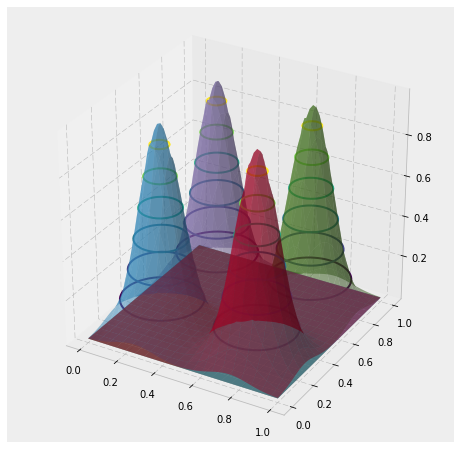

In [12]:
plt.rcParams["figure.figsize"] = (8,8)

fig = plt.figure()
ax = fig.gca(projection='3d')

for z in Z :
    surf = ax.plot_surface(X, Y, z, rstride=3, cstride=3, alpha=0.5)
    ax.contour(X, Y, z)

plt.show()

- 회귀 시작

- 위 그림처럼 보이는 함수 $9 \times 9$개를 [0,1]사이에 배치하여 회귀

방사기저함수의 출력 모양:(81, 1, 200)
상수 항 추가 후 디자인 행렬 : (200, 82),(N,M)
W 행렬:(82, 1)
PI_pred : (2500, 82)
T_pred : (50, 50)


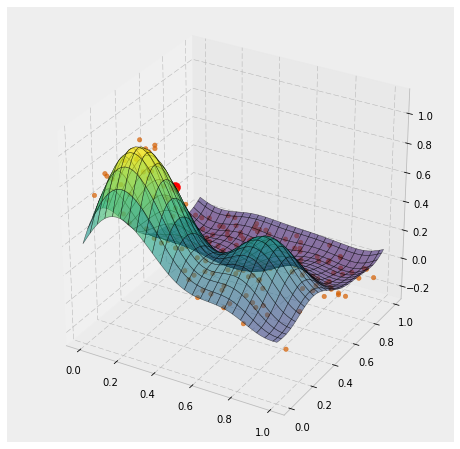

In [13]:
plt.rcParams["figure.figsize"] = (8,8)

# hyper param. 2018/01/05 set
lamda = 1.5 #regularization param.
span = np.linspace(0, 1, 10)
# [0, 1]사이를 9개로 쪼개고 
# 9x9 를 중심으로 하는 그리드를 만든다.
mu = (span[:-1] + span[1:])/2
MU_X, MU_Y = np.meshgrid(mu, mu)
M = mu.shape[0]**2
s = 0.1

# make design matrix
# X_train[0,:]: (200,)
PI = rbf(X_train[0,:],X_train[1,:], MU_X, MU_Y, s)
print("방사기저함수의 출력 모양:{}".format(PI.shape)) #(81, 1, 200)
PI = PI.transpose((1, 2, 0)) #(1, 200, 81)
PI = PI.reshape(N, -1) # (200, 81)
#1번 열에 상수 1 추가
PI = np.hstack((np.ones(PI.shape[0]).reshape(-1,1), PI))
print("상수 항 추가 후 디자인 행렬 : {},(N,M)".format(PI.shape))  # (200, 82) (NxM)

# solve normal eq.                          reg. term   lambda*I
W = np.dot( np.linalg.inv(np.dot(PI.T, PI) + lamda*np.eye(PI.shape[1]) ) , np.dot(PI.T , T_train.reshape(N,1)) )
print("W 행렬:{}".format(W.shape))

# for surface plot
# 2500 점에 대해서 회귀식의 값을 구해서 surface plot
N2 = 50
x = np.linspace(0, 1, N2)
xx, yy= np.meshgrid(x,x)
    
PI_pred = rbf(xx, yy, MU_X, MU_Y, s)
PI_pred = PI_pred.reshape(M, N2*N2, -1)
PI_pred = PI_pred.transpose((2, 1, 0))
PI_pred = PI_pred.reshape(N2*N2, -1)
PI_pred = np.hstack((np.ones(PI_pred.shape[0]).reshape(-1,1), PI_pred))
T_pred = np.dot(W.T, PI_pred.T).reshape(N2,-1)
print("PI_pred : {}".format(PI_pred.shape))
print("T_pred : {}".format(T_pred.shape))

# 특정점을 주고 결과값 계산
PI_new = rbf([0.3], [0.3], MU_X, MU_Y, s)
PI_new = PI_new.reshape(M, 1*1, -1)
PI_new = PI_new.transpose((2, 1, 0))
PI_new = PI_new.reshape(1*1, -1)
PI_new = np.hstack((np.ones(PI_new.shape[0]).reshape(-1,1), PI_new))
T_new = np.dot(W.T, PI_new.T).reshape(1,-1)

fig = plt.figure()
ax = fig.gca(projection='3d')

#Plot the surface.
surf = ax.plot_surface(xx, yy, T_pred, rstride=2, cstride=2, 
                       cmap=plt.cm.viridis, edgecolor="k",
                      alpha=0.6)

#Plot data
ax.scatter(X_train[0,:], X_train[1,:], T_train, color=style_colors[4], alpha=0.7)
ax.scatter(0.3, 0.3, T_new[0][0], color='r', s=100)
ax.axis('equal')

plt.show()

In [14]:
# https://plot.ly/python/
# https://plot.ly/python/offline/
# hover contour off
# https://community.plot.ly/t/trace-lines-appearing-on-hover/5801

surf = go.Surface(x=xx, y=yy, z=T_pred, showscale=False, colorscale='Viridis', opacity=0.8,
               contours=dict(
                   x=dict(show=True, highlight=True),
                   y=dict(show=True,  highlight=True),
                   z=dict(show=True,  highlight=True),
               ),
    )

train = go.Scatter3d(x=X_train[0,:], y=X_train[1,:], z=T_train, mode='markers',
                 marker=dict(
                    symbol='circle', size=3,
                    line=dict(color=style_colors[1], width=0.5),
                    opacity=0.8,
                 ),
                 name='Data'
    )

data = [ surf, train ]
    
layout = go.Layout(
    title='Franke function',
    autosize=False, showlegend=True, 
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=30),
    scene = dict(
        xaxis = dict(title='x'),
        yaxis = dict(title='y'),
        zaxis = dict(title='z'),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [1]:
%%html
<link href='https://fonts.googleapis.com/earlyaccess/notosanskr.css' rel='stylesheet' type='text/css'>
<!--https://github.com/kattergil/NotoSerifKR-Web/stargazers-->
<link href='https://cdn.rawgit.com/kattergil/NotoSerifKR-Web/5e08423b/stylesheet/NotoSerif-Web.css' rel='stylesheet' type='text/css'>
<!--https://github.com/Joungkyun/font-d2coding-->
<link href="http://cdn.jsdelivr.net/gh/joungkyun/font-d2coding/d2coding.css" rel="stylesheet" type="text/css">
<style>
    h1     { font-family: 'Noto Sans KR' !important; color:#348ABD !important;   }
    h2     { font-family: 'Noto Sans KR' !important; color:#467821 !important;   }
    h3, h4 { font-family: 'Noto Sans KR' !important; color:#A60628 !important;   }
    p:not(.navbar-text) { font-family: 'Noto Serif KR', 'Nanum Myeongjo'; font-size: 12pt; line-height: 200%;  text-indent: 10px; }
    li:not(.dropdown):not(.p-TabBar-tab):not(.p-MenuBar-item):not(.jp-DirListing-item):not(.p-CommandPalette-header):not(.p-CommandPalette-item):not(.jp-RunningSessions-item):not(.p-Menu-item)   
            { font-family: 'Noto Serif KR', 'Nanum Myeongjo'; font-size: 12pt; line-height: 200%; }
    table  { font-family: 'Noto Sans KR' !important;  font-size: 11pt !important; }           
    li > p  { text-indent: 0px; }
    li > ul { margin-top: 0px !important; }       
    sup { font-family: 'Noto Sans KR'; font-size: 9pt; } 
    code, pre  { font-family: D2Coding, 'D2 coding' !important; font-size: 12pt !important; line-height: 130% !important;}
    .code-body { font-family: D2Coding, 'D2 coding' !important; font-size: 12pt !important;}
    .ns        { font-family: 'Noto Sans KR'; font-size: 15pt;}
    .summary   {
                   font-family: 'Georgia'; font-size: 12pt; line-height: 200%; 
                   border-left:3px solid #FF0000; 
                   padding-left:20px; 
                   margin-top:10px;
                   margin-left:15px;
               }
    .green { color:#467821 !important; }
    .comment { font-family: 'Noto Sans KR'; font-size: 10pt; }
</style>